# Exploration 09 나의 첫번째 캐글 경진대회            


## 이 노드의 루브릭           

1. 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지의 전 과정이 성공적으로 진행되었는가?     
2. 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?     
3. 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 private score 기준 110,000이하의 점수를 얻었는가?     

---

### 목차   

1. 노드 실습 결과 확인하기     
2. 데이터 다시 전처리하기       
3. 그리드 탐색으로 최적의 조합 찾기   
4. 랭킹을 올리려면? 실험하기             
5. 다시 제출하여 결과 알아보기         

---   

## 1. 노드 실습 결과 확인하기                          

- 노드에서 안내하는대로,                  
- 1. 데이터 결측치 확인         
- 2. 데이터 전처리(id분리, date 값을 6자리까지 살려 년,월의 정보만 반영)          
- 3. 부스팅 모델 조합            

등의 과정을 거쳐 score를 확인하였다. 

---

In [8]:
# os.getenv('HOME')+ '/SUBMIT_MISSION_GIT/ex9_Kaggle/Data'

import pandas as pd
import numpy as np

![1차결과확인](./PostingPic/9_1차결과물.png)

> -  1차 제출 결과를 확인하니, Score는 1,367,741점이었다.        
> - 이 점수를 1100,000 이하로 낮출 수 있도록 하이퍼 파라미터를 조정해보자.

##### 1. 데이터를 다시 전처리해보자.        

- train, test 데이터를 가져와 date를 int 타입으로 재조정             
- 이를 통해 __date도 y값(집값:price col)을 예측하는 데이터로 활용할 수 있게 되었다.__ 

In [9]:
new_path = os.getenv('HOME')+ '/SUBMIT_MISSION_GIT/ex9_Kaggle/Data'

new_train_path = join(new_path, 'train.csv')
new_test_path = join(new_path, 'test.csv')

new_train = pd.read_csv(new_train_path)
new_test = pd.read_csv(new_test_path)

print("새로 데이터 가져오기")

새로 데이터 가져오기


In [10]:
new_train.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [11]:
#date를 새로 세팅(정수형 데이터로)

new_train['date'] = new_train['date'].apply(lambda i:i[:6]).astype(int)
new_train.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [12]:
#price 컬럼을 따로 저장하여, new_train의 타겟 데이터(정답)를 분리

new_train_target = new_train['price']
del new_train['price']

new_train.head(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [13]:
#테스트도 동일 처리

new_test['date'] = new_test['date'].apply(lambda i:i[:6]).astype(int)

del new_test['id']
new_test.head(5)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


##### 2. 특별히 치우쳐진 데이터가 없는지 확인하고, 조정한다.         

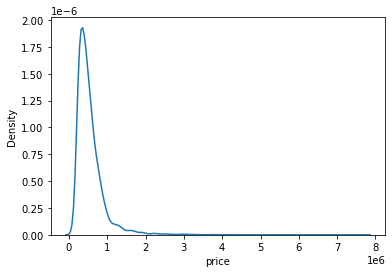

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(new_train_target)
plt.show()

> - target 데이터를 확인했을 때, 치우쳐져 있으므로 노드 실습에서 적용한 로그 변환을 통해 분포를 고르게 한다.

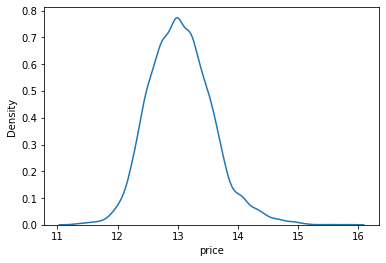

In [15]:
new_train_target = np.log1p(new_train_target)
sns.kdeplot(new_train_target)
plt.show()

## 3. 그리드 서치를 통해, 최적의 조합 찾기

##### 1. 그리드 서치를 통해, 모델에서 가장 높은 결과를 뽑아낼 수 있는 하이퍼 파라미터 조합을 찾는다.          

In [16]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

print('함수 세팅')

함수 세팅


In [17]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex9_Kaggle/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    
print('submission 함수 세팅')

submission 함수 세팅


##### 2. 처음 노드 실습을 통해 그리드 서치로 최적의 조합을 찾았을 때

- 위의 'myGridSearch'를 통해 최적의 조합을 찾고, 실험하였을 때

![최적의 조합 첫 시도](./PostingPic/그리드첫시도.png)         

- score가 1300000 에서 1150000대로 감소하였다.

##### 3. 다양한 시도를 통해 최적의 조합을 찾아보자           

- 노드 실습을 통해 시험해 본 4개의 조합은     
- n_estimator, max_depth 각각 2개씩 4개의 조합이었기 때문에,   

> - 이 파라미터를 변경하여 다시 한 번 최적의 조합을 찾는다.      
> - 다른 모델에 최적의 조합을 적용해본다.     

- 의 2가지 경우(다양한 배리에이션 적용 가능)가 있다.

###### 3-1. param_grid의 새로운 적용            

- 모델은 lightgbm으로 그대로 둔 채, 파라미터 grid를 변경해본다.

In [18]:
#n_estimators : 반복하려는 트리의 개수
#max_depth : 트리의 최대 깊이
#학습률도 중요한 요소이므로, 학습률을 변경해본다.
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 100],
    'learning_rate' : [0.001, 0.01],
}

In [23]:
#머신러닝 모델
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

print('모델 임포팅 완료')

random_state = 2021

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, new_train, new_train_target, param_grid, verbose=2, n_jobs=5)

모델 임포팅 완료
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    2.3s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,score,RMSLE
5,0.010,10,100,-0.081080,0.284745
7,0.010,100,100,-0.081080,0.284745
4,0.010,10,50,-0.138643,0.372348
6,0.010,100,50,-0.138643,0.372348
1,0.001,10,100,-0.239401,0.489286
3,0.001,100,100,-0.239401,0.489286
0,0.001,10,50,-0.258047,0.507983
2,0.001,100,50,-0.258047,0.507983


> - 최적의 조합은 러닝 레이트 0.01, max_depth=10, n_estimator=100이었다. 
> - 조합을 비교해 보았을 때, 러닝 레이트 > n_estimators > max_depth 순으로 영향을 미치는 것을 확인할 수 있다.

__이 조합을 파일로 저장하여 제출해보자!__

In [36]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    
    #모델을 학습시킴
    model.fit(train, y)
    
    #예측 및 예측값 복원(RMSLE->RMSE)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    #저장 위치 지정 및 submission_file과 같은 형태로 덮어씌우기
    data_dir = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    
    #파일로 저장
    submission_csv_path = '{}/submission.csv'.format(data_dir)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    
print('submission 함수 세팅')

submission 함수 세팅


In [37]:
save_submission(model, new_train, new_train_target, new_test, 'lgbm', rmsle='0.0168')

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit/submission.csv saved!


> -  저장된 submission을 출력해보자.

In [41]:
data_dir = os.getenv('HOME')+'/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit'

submission_path = join(data_dir, 'submission.csv')
submission = pd.read_csv(submission_path)

submission.head(5)

,id,price
0,15035,4.987774e+05
1,15036,4.754889e+05
2,15037,1.380315e+06
3,15038,3.123854e+05
4,15039,3.305570e+05


> - 이 파일을 제출하여, public score를 확인해보자.

__결과 확인!__

![두번째](./PostingPic/그리드두번째.png)            

- 아까보다 아주 조금이지만, score가 줄었다!

##### 3-1-2. 다시 한 번 시도!           

- 학습률과 기타 파라미터를 재조정해서, 다시 한 번만 더 줄여보자.     
- 어쩌면 110,000 밑으로 줄일 수 있을지도 모른다!   

### 3번째 시도

In [42]:
#n_estimators : 반복하려는 트리의 개수
#max_depth : 트리의 최대 깊이
#학습률도 중요한 요소이므로, 학습률을 변경해본다.
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate' : [0.001, 0.01],
}

> - 아까 결과를 확인했을때, 학습률 > 트리개수 > 최대깊이 순으로 영향을 미쳤다.   
> - 해커톤에서 확인했을 때, 학습률은 0.01이 가장 좋았으므로 그대로 둔다.

In [43]:
random_state = 2021

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, new_train, new_train_target, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:    3.3s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.010,10,200,-0.043846,0.209394
5,0.010,5,200,-0.046714,0.216135
6,0.010,10,100,-0.081080,0.284745
4,0.010,5,100,-0.083700,0.289310
3,0.001,10,200,-0.207100,0.455083
1,0.001,5,200,-0.208088,0.456167
2,0.001,10,100,-0.239401,0.489286
0,0.001,5,100,-0.239913,0.489809


> - 트리의 개수가 늘어날 수록, 결과는 더 좋아진다는 것을 알 수 있다.    

In [46]:
model = LGBMRegressor(max_depth=10, n_estimators=200, learning_rate=0.01, random_state=random_state)
model.fit(new_train, new_train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=200,
              random_state=2021)

In [47]:
save_submission(model, new_train, new_train_target, new_test, 'lgbm', rmsle='0.0168')

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit/submission.csv saved!


In [48]:
submission = pd.read_csv(submission_path)

submission.head(5)

,id,price
0,15035,4.796500e+05
1,15036,4.195866e+05
2,15037,1.145742e+06
3,15038,3.269627e+05
4,15039,3.227191e+05


![결과](./PostingPic/세번째결과.png)              

- 더..늘어나버렸다.. 원래 걸 하는 걸로...        
- 과적합 되었을 가능성을 생각해 볼 수 있다.

##### 3-2. 새로운 모델 설정                     

### 4번째 시도

In [63]:
xgboost = xgb.XGBRegressor(random_state=2021)
lightgbm = lgb.LGBMRegressor(random_state=2021)

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print("모델 세팅 완료!")

모델 세팅 완료!


> 부스팅 계열의 앙상블 모델을 2개로 줄여 테스트해본다.

In [64]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2021).get_n_splits(new_train.values)
    
    for m in models:
        print("모델 {} 성능 평가 수치 : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], new_train.values, new_train_target)), kf=kfold))


print("완료")

완료


In [65]:
get_cv_score(models)

/home/ssac23/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


모델 XGBoost 성능 평가 수치 : 0.8973
모델 LightGBM 성능 평가 수치 : 0.9025


> 두 모델의 평균(에버리징)을 내어 새롭게 결과를 예측한다.

In [66]:
def AveragingBlending(models, x, y, test):
    for m in models:
        m['model'].fit(x.values, y)
        
    predictions = np.column_stack([m['model'].predict(test.values) for m in models])
    
    return np.mean(predictions, axis=1)

print("함수 설정완료")

함수 설정완료


In [68]:
y_prediction = AveragingBlending(models, new_train, new_train_target, new_test)

In [77]:
y_prediction

array([13.11480437, 13.06002629, 14.08119752, ..., 13.04942107,
       12.69892454, 13.01982138])

In [82]:
result = pd.DataFrame({'id': new_id, 'price':y_prediction})

result.tail(5)

,id,price
6463,21498,12.455919
6464,21499,12.899808
6465,21500,13.049421
6466,21501,12.698925
6467,21502,13.019821


In [83]:
file_save_path = join(data_path, 'submission_4_2.csv')
result.to_csv(file_save_path, index=False)

print(file_save_path)

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle/Data/submission_4_2.csv


In [84]:
#new_id = id_list['id']
#id 오류가 났기 때문에...

![결과 너무함](./PostingPic/네번째결과.png)

> - 결과... 너무 처참했다. 다시 lightGBM으로 돌아가서 파라미터 조정을 해보자.

##### 3-1-4. 원점으로 돌아와서 다시 파라미터 조정                   

### 5번째 시도는 분실했고(덮어씌움...) 6번째 시도

In [96]:
model6 = LGBMRegressor(max_depth=5, n_estimators=200, learning_rate=0.01, random_state=random_state)
model6.fit(new_train, new_train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=200,
              random_state=2021)

In [97]:
save_submission(model6, new_train, new_train_target, new_test, 'lgbm')

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit/submission.csv saved!


In [98]:
submission = pd.read_csv(submission_path)

submission.head(5)

,id,price
0,15035,4.817898e+05
1,15036,4.044751e+05
2,15037,1.131943e+06
3,15038,3.207168e+05
4,15039,3.169830e+05


![다섯번째 결과](./PostingPic/다섯번째결과.png)

> - 다시 많이 줄었다!                

### 7번째 시도

In [100]:
model7 = LGBMRegressor(max_depth=5, n_estimators=500, learning_rate=0.01, random_state=random_state)
model7.fit(new_train, new_train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
              random_state=2021)

In [101]:
save_submission(model7, new_train, new_train_target, new_test, 'lgbm')

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit/submission.csv saved!


In [102]:
submission = pd.read_csv(submission_path)

submission.head(5)

,id,price
0,15035,5.131053e+05
1,15036,4.182120e+05
2,15037,1.263524e+06
3,15038,3.121000e+05
4,15039,3.198759e+05


![결과가 많이 줄었다](./PostingPic/여섯번째결과.png)

> - 다시 많이 줄어들었다!      
> - 뎁스를 짧게 하되, 좌우의 너비를 넓히는 것이 도움이 되었다.

### 8번째 시도    

In [103]:
model8 = LGBMRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01, random_state=random_state)
model8.fit(new_train, new_train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
              random_state=2021)

In [104]:
save_submission(model8, new_train, new_train_target, new_test, 'lgbm')

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit/submission.csv saved!


In [105]:
submission = pd.read_csv(submission_path)

submission.head(5)

,id,price
0,15035,5.138500e+05
1,15036,4.248100e+05
2,15037,1.335816e+06
3,15038,3.085757e+05
4,15039,3.264272e+05


![일곱번째결과](./PostingPic/일곱번째결과.png)

> - 워오 많이 따라잡았다

### 9번째 시도

In [107]:
model9 = LGBMRegressor(max_depth=5, n_estimators=5000, learning_rate=0.01, random_state=random_state)
model9.fit(new_train, new_train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=5000,
              random_state=2021)

In [108]:
save_submission(model9, new_train, new_train_target, new_test, 'lgbm')

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit/submission.csv saved!


In [109]:
submission = pd.read_csv(submission_path)

submission.head(5)

,id,price
0,15035,5.262080e+05
1,15036,4.603523e+05
2,15037,1.422002e+06
3,15038,2.894021e+05
4,15039,3.283885e+05


![성공](./PostingPic/여덟번째결과.png)

### 10번째 시도

In [111]:
model10 = LGBMRegressor(max_depth=5, n_estimators=10000, learning_rate=0.01, random_state=random_state)
model10.fit(new_train, new_train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=10000,
              random_state=2021)

In [112]:
save_submission(model10, new_train, new_train_target, new_test, 'lgbm')

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit/submission.csv saved!


In [113]:
submission = pd.read_csv(submission_path)

submission.head(5)

,id,price
0,15035,5.290363e+05
1,15036,4.764025e+05
2,15037,1.382617e+06
3,15038,2.903863e+05
4,15039,3.290092e+05


### 10번째 시도

In [114]:
model11 = LGBMRegressor(max_depth=10, n_estimators=10000, learning_rate=0.01, random_state=random_state)
model11.fit(new_train, new_train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=10000,
              random_state=2021)

In [115]:
save_submission(model11, new_train, new_train_target, new_test, 'lgbm')

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit/submission.csv saved!


In [116]:
submission = pd.read_csv(submission_path)

submission.head(5)

,id,price
0,15035,5.005569e+05
1,15036,4.956828e+05
2,15037,1.250180e+06
3,15038,3.034497e+05
4,15039,3.324491e+05


### 12번째 시도

In [117]:
model12 = LGBMRegressor(max_depth=10, n_estimators=20000, learning_rate=0.01, random_state=random_state)
model12.fit(new_train, new_train_target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=20000,
              random_state=2021)

In [118]:
save_submission(model12, new_train, new_train_target, new_test, 'lgbm')

/home/ssac23/SUBMIT_MISSION_GIT/ex9_Kaggle_submit/Submit/submission.csv saved!


In [119]:
submission = pd.read_csv(submission_path)

submission.head(5)

,id,price
0,15035,4.990251e+05
1,15036,5.017854e+05
2,15037,1.198926e+06
3,15038,3.010652e+05
4,15039,3.215947e+05


> - 파라미터를 많이 늘려도 학습되는 비율이 현저히 줄어 다른 파라미터를 설정해 줄 필요를 느꼈다. 한 트리가 가지는 leaf의 개수를 줄여 과적합을 줄여보기로 했다. 

## 성공했다!!!!! 스코어 108053으로 11만 밑으로 내려갔다.     
- 주효한 전략은      
- 1. depth 줄여서 깊이를 얕게 만들기       
- 2. 반복하려는 트리 개수를 늘리기(마지막에는 1000개->5000개로 갯수를 확 늘렸다.)     



![총시도](./PostingPic/총시도.png)

- 중간에 많은 에러가 났었다는 것을 알 수 있다.(특히 4번째 시도에서는 id컬럼을 잘못 설정해서 오류가 났다)

![최종등수](./PostingPic/등수.png)                


> 이미 최종제출일이 지났기 때문에 public score 등수를 확인할 수는 없지만, 점수로 미뤄보았을 때         
> 대강 47~48등의 사이 정도에 위치할 것 같다.(물론 제출되지 않았으므로 픽스는 아니지만!)

__오잉 여기까지 적고서 눈치챘는데 public score가 아니라 private score를 줄여야..?__

### 결국 다시 private score를 줄이기 위해 시도...

- 중간과정은 수치가 너무 비슷하게 나와서 생략한다.   
- 하지만 결국 해내고 말았다!

# private score 109967점으로 성공!
### 수를 세어봤더니... 몇 번 숫자를 잘못 세서 그렇지 15번째 결과였다.    

- 한 트리의 leaf 수를 20개로 한정하고,     
- 뎁스를 조금 더 깊이 파고(10개), 트리의 수를 확 늘렸다(2만)      
- public score는 더 높아졌지만(다시 11만대로 복귀), private socre 기준으로는 11만 이하로 떨어졌다.     

In [ ]:
model13 = LGBMRegressor(max_depth=10, n_estimators=20000, learning_rate=0.01, num_leaves=20,random_state=random_state)
model13.fit(new_train, new_train_target)

In [ ]:
save_submission(model13, new_train, new_train_target, new_test, 'lgbm')

![15번째 결과](./PostingPic/15번째결과.png)

### 이번 노드로 인해 깨달은 것                    

#### 아 캐글 너모 어려웠지만...                    

- AI를 시작하기 전, 직장에서 캐글 책을 보고 '언젠가 한 번은 해봐야지'라고 생각했었는데 이번 기회를 통해 해볼 수 있어 좋았다.    
- 데이터 전처리에 대한 두려움이 있었는데, 이번 노드를 진행하면서 두려움이 많이 적어진 것 같다.            

--- 
- 모델의 특성에 대해 이해하고, 파라미터를 조정하는 것이 중요하다는 것을 깨달았다.  - 이번에는 단일 모델의 파라미터 조정을 통해 목표를 달성했지만, 다음에는 부스팅 모델의 앙상블로도 11만점 이하의 점수에 도달해보고 싶다.

---
- 해커톤에서는 솔직히 좋은 점수를 내지 못해 너무 아쉬웠다. 팀 전체가 정말 열심히 했지만, 데이터를 전처리 하는 과정에서 감을 잡기가 너무 어려웠고, 우리만의 코드를 만들어가고자 했지만 역량적으로 부족했었던 것 같다.              
- 다만 우리 팀을 만난 것은 너무 좋았다. 팀원들이 열심히 하는 모습을 보고, 대화를 나누며 AI에 대한 열정이 다시 북돋아지는 기분이 들었다.         
